In [18]:
#parse data files into pandas csv
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### process data

In [2]:
!ls

changes           final_general.col final_general.dat parse.ipynb


In [3]:
len(np.array(pd.read_fwf('final_general.dat'))[0][0].split(' '))

72

In [4]:
def parse_data(str, num_col=69):
    """convert .txt file of feature space into a pandas csv file"""
    data = np.array(pd.read_fwf(str))
    observations = [[]]*len(data)
    for i, x in enumerate(data):
        x = x[0].split(' ')
        features = [None]*num_col
        for j, val in enumerate(x):
            if val and val.isdigit() and j < num_col:
                features[j] = int(val)
        observations[i] = features
    return np.array(observations)

In [5]:
x = 'final_general.dat'
data = parse_data(x)
data = [[item for item in row] for row in data]

In [6]:
column_names = np.array(pd.read_fwf('final_general.col')).T[0]

In [7]:
df = pd.DataFrame(data, columns=column_names)

In [8]:
df = df.dropna()

In [13]:
X = np.array(df)
df.head()

,Age,Community Building,Community Membership_Family,Community Membership_Hobbies,Community Membership_None,Community Membership_Other,Community Membership_Political,Community Membership_Professional,Community Membership_Religious,Community Membership_Support,...,Web Ordering,Web Page Creation,Who Pays for Access_Don't Know,Who Pays for Access_Other,Who Pays for Access_Parents,Who Pays for Access_School,Who Pays for Access_Self,Who Pays for Access_Work,Willingness to Pay Fees,Years on Internet
0,2,28,2,0,0,0,0,0,0,0,...,1,1,1,2,0,0,0,0.0,1.0,0.0
1,99,25,0,1,1,0,0,0,1,0,...,2,1,1,1,0,0,0,0.0,1.0,1.0
2,29,28,0,0,0,0,1,0,0,0,...,1,1,1,1,0,0,0,0.0,1.0,0.0
3,15,17,0,0,0,0,0,1,1,0,...,2,1,1,1,0,0,0,0.0,1.0,0.0
4,99,55,2,1,0,0,0,0,1,1,...,1,1,1,1,0,0,0,0.0,1.0,1.0


### cluster data (self-annotation)

In [14]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [22]:
centroids = kmeans.cluster_centers_ #get the cluster center points

In [26]:
labels = kmeans.labels_ #get all labels for all points in the dataset

In [27]:
df['Label']= labels

In [44]:
df.head()
print(df.shape)

(7401, 70)


[]

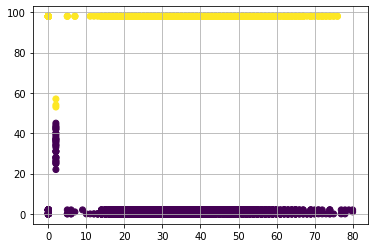

In [41]:
def plot(feature_1, feature_2):
    return X.T[feature_1], X.T[feature_2]

plt.scatter(*plot(1, 2), c=labels)
plt.grid()
plt.plot()

### Build NN

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time #check min_threshold values for cloud storage
from sklearn.model_selection import train_test_split #don't use for time-series baseline!
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

### Process data into Tensors

In [46]:
#split into training and testing
X = df.drop('Label',axis=1).values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
print(f"Training data feature space: {X_train.shape}")
print(f"Testing data feature space: {X_test.shape}")

Training data feature space: (5920, 69)
Testing data feature space: (1481, 69)


In [50]:
### Create tensors from np.ndarry main data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

### Model

In [55]:
class NN(nn.Module):
    def __init__(self, input_features=69, layer1=30, layer2=20, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(input_features, layer1)
        self.fc2 = nn.Linear(layer1, layer2)
        self.out = nn.Linear(layer2, out_features)
        
    def forward(self, x):
        """Forward pass with 69 input features"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [70]:
# initialize model
model = NN()
# implement backprop
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #adam works well for this.

### Train Model

In [62]:
def train(epochs=int(1e3), print_every=100, epsilon=0.5):
    """
    Train the model.
    - assumes access to following global variables: X_train, y_train, y_pred, model, loss function, & optimizer.
    @Param:
    1. epochs - number of training iterations.
    2. print_every - for visual purposes (set to None to ignore), outputs loss
    3. epsilon - threshold to break training.
    """
    start_time = time.time() #set start time
    losses = [] #plot
    
    for i in range(1, epochs+1):
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        losses.append(loss)
        #Tensor(223).item() -> 223
        if(loss.item() <= epsilon):
            print(f"\nCONVERGED at epoch {i} - loss : {loss.item()}")
            break #converged
        
        if(print_every is not None and i%print_every == 1):
            print(f"Epoch {i} - loss : {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("total training time (sec):", time.time()-start_time)
    return losses

In [63]:
cost = train(epochs=int(1e4), epsilon=0.1)

Epoch 1 - loss : 0.6586352586746216

CONVERGED at epoch 7 - loss : 0.08190286159515381
total training time (sec): 0.030742168426513672


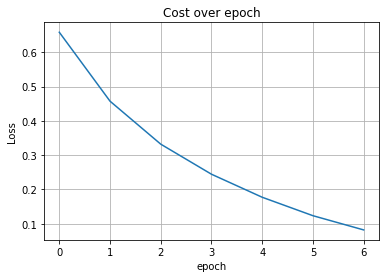

In [64]:
#graph cost
plt.plot(cost)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Cost over epoch")
plt.grid()
plt.show()

In [65]:
#### predict X_test data
predictions=[]
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())
        
predictions = np.array(predictions, dtype=np.int8)

In [68]:
score = accuracy_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [69]:
print("Accuracy", score)
print("***Confusion Matrix stats***")
print(f"True Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive: {tp}")

Accuracy 0.9959486833220796
***Confusion Matrix stats***
True Negative: 1087
False Positive: 0
False Negative: 6
True Positive: 388


### Upload Model

In [78]:
#Read more: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), "../attribution/model/internet_usage_model.pth")
### save tensors
torch.save([X_train, y_train], '../attribution/data/internet_usage/tensor_train.pt')
torch.save([X_test, y_test],   '../attribution/data/internet_usage/tensor_test.pt')

### Correlation Plots

In [75]:
covariance = np.cov(X_train.T) / (X_train.mean() * np.mean(y_train.detach().numpy()))
n = len(covariance)
for i in range(n):
    covariance[i][i] = 0

In [79]:
import plotly.express as px
fig = px.imshow(covariance, labels=dict(x='Feature Inputs', y='Feature Inputs', color="Correlation"))
fig.show()